Active and passive remote sensors onboard orbitting satellites usually collect multiple spectral bands. The combination of several of these bands can often be used to characterize land surface features, like vegetation, water bodies, and wildfires.

In this example we will use the red and near infrared bands from Sentinel 2 satellite of the European Space Agency to compute the normalized difference vegetation index at 10-meter spatial resolution for a production field in Argentina.

In [1]:
# Import modules
import ee
import json
import requests
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr
import pandas as pd


In [2]:
# Authenticate
#ee.Authenticate()

# Initialize API
ee.Initialize()


In [4]:
# Import boundary for area of interest (aoi)
with open('../datasets/field_bnd_carmen.geojson') as file:
    aoi_json = json.load(file)

# Define the ee.Geometry
aoi = ee.Geometry(aoi_json['features'][0]['geometry'])

# Create mask for field
mask = ee.Image.constant(1).clip(aoi).mask()


In [5]:
# Define start and end dates
start_date = '2023-01-10'
end_date = '2023-01-30'


In [6]:
# Load Sentinel-2 image collection
S2 = ee.ImageCollection('COPERNICUS/S2') \
                .filterDate(start_date, end_date) \
                .filterBounds(aoi) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                .select(['B8', 'B4'])  # B8 is NIR, B4 is Red

In [7]:
# Print the following line to explore the selected images
#S2.getInfo()['features']

In [8]:
def calculate_ndvi(image):
    """
    Function to calculate NDVI for a single image.
    """
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Apply the NDVI function to each image in the collection
ndvi_collection = S2.map(calculate_ndvi)


In [9]:
# Apply the function to add mean NDVI as a property
ndvi_mean = ndvi_collection.reduce(ee.Reducer.mean())

# Mask ndvi image
ndvi_mean = ndvi_mean.mask(mask)


In [10]:
# Inspect resulting image (note the the new band is "NDVI_mean"
ndvi_mean.select('NDVI_mean').getInfo()

{'type': 'Image',
 'bands': [{'id': 'NDVI_mean',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': -1,
    'max': 1},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [11]:
# Get url link for image
image_url = ndvi_mean.getDownloadUrl({'region': aoi,'scale':10,
                                      'bands':['NDVI_mean'],
                                     'crs': 'EPSG:4326', 
                                     'format': 'GEO_TIFF'})
    
# Request data using URL and save data as a new GeoTiff file
response = requests.get(image_url)

# Save geotiff image to local drive
filename = '../outputs/field_carmen_ndvi.tiff'
with open(filename, 'wb') as f:
    f.write(response.content)


In [12]:
# Read saved geotiff image from local drive
ndvi_raster = xr.open_dataarray(filename).squeeze()


In [13]:
df = pd.DataFrame(aoi_json['features'][0]['geometry']['coordinates'][0])
df.columns = ['lon','lat']
df.head(3)


,lon,lat
0,-61.792900,-33.750588
1,-61.790372,-33.753893
2,-61.784847,-33.750976


In [14]:
# Create colormap
hex_palette = ['#FEFEFE','#CE7E45', '#DF923D', '#F1B555', '#FCD163', '#99B718', '#74A901',
             '#66A000', '#529400', '#3E8601', '#207401', '#056201', '#004C00', '#023B01',
             '#012E01', '#011D01', '#011301']

# Use the built-in ListedColormap function to do the conversion
rgb_cmap = colors.ListedColormap(hex_palette)


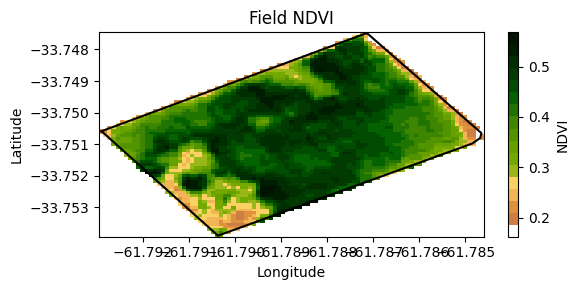

In [15]:
# Create figure
ndvi_raster.plot.imshow(figsize=(6,3), cmap=rgb_cmap, add_colorbar=True,
                   cbar_kwargs={'label':'NDVI'})

plt.plot(df['lon'], df['lat'],'-k')
plt.title('Field NDVI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()